In [1]:
from rdkit import Chem
from arc.species import ARCSpecies

/home/calvin/code/RMG-Py/rmgpy/rmg/reactors.py:53: RuntimeWarning: Unable to import Julia dependencies, original error: No module named 'julia'
  warnings.warn("Unable to import Julia dependencies, original error: " + str(e), RuntimeWarning)
/home/calvin/miniforge3/envs/arc_env/lib/python3.7/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
suppl_path = "/home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_265.sdf"
suppl = Chem.SDMolSupplier(suppl_path, removeHs=False)
mol = suppl[0]

In [3]:
import ast
ast.literal_eval(mol.GetProp("mol_properties"))

{'1': {'label': 'donator', 'atom_type': 'Cs'},
 '8': {'label': 'd_hydrogen', 'atom_type': 'H0'}}

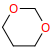

In [4]:
# Get the coords from the mol and save them as a str, atoms X Y Z \n
coords = []
for atom in mol.GetAtoms():
    pos = mol.GetConformer().GetAtomPosition(atom.GetIdx())
    coords.append(f"{atom.GetSymbol()} {pos.x:.4f} {pos.y:.4f} {pos.z:.4f}")
coords_str = "\n".join(coords)
# Create an ARCSpecies object

species = ARCSpecies(
    label="rxn_615",
    xyz=coords_str,
)
species.mol

In [5]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem import AllChem

def get_distance(coords, i, j):
    return np.linalg.norm(coords[i] - coords[j])

def get_angle(coords, i, j, k):
    # Angle at j (i-j-k)
    v1 = coords[i] - coords[j]
    v2 = coords[k] - coords[j]
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.arccos(np.clip(cos_theta, -1, 1))

def get_dihedral(coords, i, j, k, l):
    # Dihedral angle between i-j-k-l
    p0, p1, p2, p3 = coords[i], coords[j], coords[k], coords[l]
    b0 = -1.0 * (p1 - p0)
    b1 = p2 - p1
    b2 = p3 - p2
    b1 /= np.linalg.norm(b1)
    v = b0 - np.dot(b0, b1) * b1
    w = b2 - np.dot(b2, b1) * b1
    x = np.dot(v, w)
    y = np.dot(np.cross(b1, v), w)
    return np.arctan2(y, x)

def get_mol_coords(mol):
    """Returns (num_atoms, 3) array of atom positions from the first conformer."""
    conf = mol.GetConformer()
    num_atoms = mol.GetNumAtoms()
    coords = np.array([list(conf.GetAtomPosition(i)) for i in range(num_atoms)])
    return coords

def compute_atomfeats(mol, label, d_hydrogen_label=('d_hydrogen', 'a_hydrogen')):
    num_atoms = mol.GetNumAtoms()
    conf = mol.GetConformer()
    coords = np.array([list(conf.GetAtomPosition(i)) for i in range(num_atoms)])
    d_hydrogen_idx = int([k for k, v in label.items() if v["label"] in d_hydrogen_label][0])

    feat_records = []
    for target_idx in range(num_atoms):
        record = {'atom_idx': target_idx, 'path': None, 'features': None}
        if target_idx == d_hydrogen_idx:
            record['path'] = [target_idx]
            record['features'] = [np.nan, np.nan, np.nan, 0, 0, 0]
            feat_records.append(record)
            continue
        path = list(rdmolops.GetShortestPath(mol, d_hydrogen_idx, target_idx))
        plen = len(path)
        # r_exist, A_exist, D_exist
        flags = [0, 0, 0]
        radius = angle = dihedral = np.nan
        if plen >= 2:
            flags[0] = 1
            radius = get_distance(coords, d_hydrogen_idx, target_idx)
        if plen >= 3:
            flags[1] = 1
            angle = get_angle(coords, d_hydrogen_idx, path[1], target_idx)
        if plen >= 4:
            flags[2] = 1
            dihedral = get_dihedral(coords, d_hydrogen_idx, path[1], path[2], target_idx)
        record['path'] = path
        record['features'] = [radius, angle, dihedral, *flags]
        feat_records.append(record)
    return feat_records


atom_feats = compute_atomfeats(mol,ast.literal_eval(mol.GetProp("mol_properties")) )


In [6]:
atom_feats_records = compute_atomfeats(mol, ast.literal_eval(mol.GetProp("mol_properties")))
for rec in atom_feats_records:
    print(f"Atom: {rec['atom_idx']}, Path: {rec['path']}, Features: {rec['features']}")


Atom: 0, Path: [8, 1, 0], Features: [1.9147767755015206, 1.8878312255262182, nan, 1, 1, 0]
Atom: 1, Path: [8, 1], Features: [0.8000392115390346, nan, nan, 1, 0, 0]
Atom: 2, Path: [8, 1, 2], Features: [1.7667867839668714, 1.810880776992956, nan, 1, 1, 0]
Atom: 3, Path: [8, 1, 2, 3], Features: [2.9578892237539933, 2.396447003854575, -2.9775966140426138, 1, 1, 1]
Atom: 4, Path: [8, 1, 0, 5, 4], Features: [3.426752831763622, 2.455829356497438, 2.4196233869830635, 1, 1, 1]
Atom: 5, Path: [8, 1, 0, 5], Features: [3.1370587275344404, 2.4784704699082685, 2.8656092714965884, 1, 1, 1]
Atom: 6, Path: [8, 1, 0, 6], Features: [2.4039601203014995, 1.7215506431439112, -1.2924039864061734, 1, 1, 1]
Atom: 7, Path: [8, 1, 0, 7], Features: [2.2438601048193716, 1.5208980652576003, 0.7890302429502145, 1, 1, 1]
Atom: 8, Path: [8], Features: [nan, nan, nan, 0, 0, 0]
Atom: 9, Path: [8, 1, 9], Features: [1.5224802166202358, 1.8442160957145541, nan, 1, 1, 0]
Atom: 10, Path: [8, 1, 2, 3, 10], Features: [3.322177

In [7]:
def safe_flag(val):
    return 0 if np.isnan(val) else int(val)

def print_atomfeats_pyramid_reorder_dict(mol, atomfeats_records, degrees=True):
    """
    Print atom features from a list of dicts (with 'atom_idx', 'features', etc.)
    If degrees=True, angles/dihedrals are shown in degrees.
    """
    headers = ["ATOM", "IDX", "R", "A", "D", "R_Exist", "A_Exist", "D_Exist"]
    print("{:<4} {:<3} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}".format(*headers))
    record = {}
    # Compute number of nans for sorting (R, A, D only)
    for rec in atomfeats_records:
        i = rec['atom_idx']
        values = rec['features'][:3]
        num_nans = np.sum(np.isnan(values))
        record[i] = num_nans
    # Sort by number of Nans (descending)
    sorted_atoms = sorted(record.items(), key=lambda x: x[1], reverse=True)
    for idx, num_nans in sorted_atoms:
        rec = next(r for r in atomfeats_records if r['atom_idx'] == idx)
        atom = mol.GetAtomWithIdx(idx)
        vals = np.array(rec['features']).copy()
        # Convert radians to degrees if desired
        if degrees:
            if not np.isnan(vals[1]):
                vals[1] = np.rad2deg(vals[1])
            if not np.isnan(vals[2]):
                vals[2] = np.rad2deg(vals[2])
        strvals = []
        for x in vals:
            if np.isnan(x):
                strvals.append("   nan  ")
            elif float(x).is_integer():
                strvals.append(f"{int(x):8d}")
            else:
                strvals.append(f"{x:8.4f}")
        print("{:<4} {:<3} {}".format(atom.GetSymbol(), idx, " ".join(strvals)))





print("\nAtom Features Pyramid:")
print_atomfeats_pyramid_reorder_dict(mol, atom_feats, degrees=True)


Atom Features Pyramid:
ATOM IDX        R        A        D  R_Exist  A_Exist  D_Exist
H    8      nan      nan      nan          0        0        0
C    1     0.8000    nan      nan          1        0        0
C    0     1.9148 108.1648    nan          1        1        0
O    2     1.7668 103.7558    nan          1        1        0
H    9     1.5225 105.6658    nan          1        1        0
C    3     2.9579 137.3063 -170.6037        1        1        1
O    4     3.4268 140.7087 138.6342        1        1        1
C    5     3.1371 142.0059 164.1873        1        1        1
H    6     2.4040  98.6376 -74.0493        1        1        1
H    7     2.2439  87.1410  45.2081        1        1        1
H    10    3.3222 150.7930 162.2670        1        1        1
H    11    3.7569 125.2326 -168.1894        1        1        1
H    12    3.5402 156.5310 -169.0613        1        1        1
H    13    4.0068 131.9279 157.4146        1        1        1


In [8]:
# Conver 1.88718 radians to degrees
import math
def radians_to_degrees(radians):
    return radians * (180.0 / math.pi)

radians_value = 1.8109    
degrees_value = radians_to_degrees(radians_value)
print(f"{radians_value} radians is {degrees_value:.2f} degrees")

1.8109 radians is 103.76 degrees


In [9]:
def print_atom_coords_xyz(mol):
    conf = mol.GetConformer()
    for i, atom in enumerate(mol.GetAtoms()):
        pos = conf.GetAtomPosition(i)
        print(f"{atom.GetSymbol():<2} {pos.x:>10.5f} {pos.y:>10.5f} {pos.z:>10.5f}")

print_atom_coords_xyz(mol)

C     1.36580   -0.49660    0.02250
C     0.40080   -0.67500    1.16750
O    -0.92870   -0.66610    0.74030
C    -1.22990    0.48350   -0.00710
O    -0.43290    0.60990   -1.14040
C     0.93600    0.71620   -0.79910
H     2.38370   -0.36870    0.39510
H     1.34190   -1.38430   -0.61480
H     0.50010   -1.41100    1.46500
H     0.56450    0.00940    2.00930
H    -1.11060    1.37350    0.63490
H    -2.26060    0.38690   -0.34060
H     1.10270    1.64020   -0.22610
H     1.48780    0.78790   -1.73560


In [10]:
import pandas as pd
import numpy as np

def atomfeats_to_table(atom_feats, d_h_idx=None):
    records = []
    for rec in atom_feats:
        idx = rec['atom_idx']
        path = rec['path']
        feats = rec['features']
        # Shortest path from d_hydrogen to this atom
        plen = len(path)
        # R: if exists (plen>=2)
        if feats[3] and plen >= 2:
            i, j = path[0], path[-1]  # 1-based indices
            records.append({
                'TYPE': 'R',
                'i': i,
                'j': j,
                'd': np.nan,
                'k': np.nan,
                'VALUE': feats[0]
            })
        # A: if exists (plen>=3)
        if feats[4] and plen >= 3:
            i, j, k = path[0], path[1], path[-1]
            angle_rad = feats[1]
            records.append({
                'TYPE': 'A',
                'i': i,
                'j': j,
                'd': int(k),
                'k': np.nan,
                'VALUE': angle_rad if not np.isnan(angle_rad) else np.nan
            })
        # D: if exists (plen>=4)
        if feats[5] and plen >= 4:
            i, j, k, l = path[0], path[1], path[2], path[-1]
            dih_rad = feats[2]
            records.append({
                'TYPE': 'D',
                'i': i,
                'j': j,
                'd': int(k),
                'k': l,
                'VALUE': dih_rad if not np.isnan(dih_rad) else np.nan
            })
    return pd.DataFrame(records)
df = atomfeats_to_table(atom_feats)
print("\nAtom Features Table:")
df


Atom Features Table:


,TYPE,i,j,d,k,VALUE
0,R,8,0,NaN,NaN,1.914777
1,A,8,1,0.0,NaN,1.887831
2,R,8,1,NaN,NaN,0.800039
3,R,8,2,NaN,NaN,1.766787
4,A,8,1,2.0,NaN,1.810881
5,R,8,3,NaN,NaN,2.957889
6,A,8,1,3.0,NaN,2.396447
7,D,8,1,2.0,3.0,-2.977597
8,R,8,4,NaN,NaN,3.426753
9,A,8,1,4.0,NaN,2.455829


In [11]:
import numpy as np
import pandas as pd
from itertools import combinations
from rdkit import Chem

def get_distance(coords, i, j):
    return np.linalg.norm(coords[i] - coords[j])

def get_angle(coords, i, j, k):
    v1 = coords[i] - coords[j]
    v2 = coords[k] - coords[j]
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.arccos(np.clip(cos_theta, -1, 1))  # Output in radians

def get_dihedral(coords, i, j, k, l):
    p0, p1, p2, p3 = coords[i], coords[j], coords[k], coords[l]
    b0 = -1.0 * (p1 - p0)
    b1 = p2 - p1
    b2 = p3 - p2
    b1 /= np.linalg.norm(b1)
    v = b0 - np.dot(b0, b1) * b1
    w = b2 - np.dot(b2, b1) * b1
    x = np.dot(v, w)
    y = np.dot(np.cross(b1, v), w)
    return np.arctan2(y, x)  # Output in radians
def enumerate_all_geometries(coords, atom_symbols=None, max_bond=2.0, only_bonded=True):
    n = coords.shape[0]
    results = []

    # Bonds: All pairs or just bonded
    for i, j in combinations(range(n), 2):
        d = get_distance(coords, i, j)
        if not only_bonded or d <= max_bond:
            results.append({
                'TYPE': 'R',
                'i': i,
                'j': j,
                'd': np.nan,
                'k': np.nan,
                'VALUE': d,
                'LABEL': f'R({i}-{j})',
                'ATOM_LABELS': f"{atom_symbols[i]}-{atom_symbols[j]}" if atom_symbols else ""
            })

    # Angles: All unique triplets
    for j in range(n):
        for i, k in combinations([x for x in range(n) if x != j], 2):
            a = get_angle(coords, i, j, k)
            results.append({
                'TYPE': 'A',
                'i': i,
                'j': j,
                'd': int(k),
                'k': np.nan,
                'VALUE': a,
                'LABEL': f'A({i}-{j}-{k})',
                'ATOM_LABELS': f"{atom_symbols[i]}-{atom_symbols[j]}-{atom_symbols[k]}" if atom_symbols else ""
            })

    # Dihedrals: All unique quartets (ordered)
    for i, j, k, l in combinations(range(n), 4):
        d = get_dihedral(coords, i, j, k, l)
        results.append({
            'TYPE': 'D',
            'i': i,
            'j': j,
            'd': int(k),
            'k': l,
            'VALUE': d,
            'LABEL': f'D({i}-{j}-{k}-{l})',
            'ATOM_LABELS': f"{atom_symbols[i]}-{atom_symbols[j]}-{atom_symbols[k]}-{atom_symbols[l]}" if atom_symbols else ""
        })
    return pd.DataFrame(results)

# --------- USAGE EXAMPLE ---------

# --- Load SDF ---
sdf_file = "/home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_265.sdf"
suppl = Chem.SDMolSupplier(sdf_file, removeHs=False)
# Load the *first* molecule
mol = suppl[0]
if mol is None:
    raise ValueError("No valid molecule found in SDF.")

# --- Extract coordinates and atom symbols ---
conf = mol.GetConformer()
coords = np.array([list(conf.GetAtomPosition(i)) for i in range(mol.GetNumAtoms())])
atom_symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]

# --- Generate geometry table ---
df_geom = enumerate_all_geometries(coords, atom_symbols=atom_symbols, max_bond=2.0, only_bonded=True)

# --- Print Chemcraft-style table ---
for _, row in df_geom.iterrows():
    if row['TYPE'] == 'R':
        print(f"{row['LABEL']:<16}{row['VALUE']:>10.3f}   {row['ATOM_LABELS']}")
    elif row['TYPE'] == 'A':
        print(f"{row['LABEL']:<16}{row['VALUE']:>10.2f}   {row['ATOM_LABELS']}")
    elif row['TYPE'] == 'D':
        print(f"{row['LABEL']:<20}{row['VALUE']:>10.2f}   {row['ATOM_LABELS']}")

# --- Optional: Save to CSV for further analysis ---
df_geom.to_csv('geometry_summary.csv', index=False)


R(0-1)               1.508   C-C
R(0-5)               1.527   C-C
R(0-6)               1.091   C-H
R(0-7)               1.093   C-H
R(0-8)               1.915   C-H
R(1-2)               1.396   C-O
R(1-8)               0.800   C-H
R(1-9)               1.097   C-H
R(2-3)               1.404   O-C
R(2-8)               1.767   O-H
R(3-4)               1.391   C-O
R(3-10)              1.104   C-H
R(3-11)              1.088   C-H
R(4-5)               1.415   O-C
R(5-12)              1.100   C-H
R(5-13)              1.089   C-H
R(6-7)               1.771   H-H
R(8-9)               1.522   H-H
R(10-11)             1.802   H-H
R(12-13)             1.776   H-H
A(1-0-2)              0.57   C-C-O
A(1-0-3)              0.99   C-C-C
A(1-0-4)              1.51   C-C-O
A(1-0-5)              1.90   C-C-C
A(1-0-6)              1.93   C-C-H
A(1-0-7)              1.91   C-C-H
A(1-0-8)              0.41   C-C-H
A(1-0-9)              0.47   C-C-H
A(1-0-10)             0.95   C-C-H
A(1-0-11)             1.0

In [12]:
df_geom

,TYPE,i,j,d,k,VALUE,LABEL,ATOM_LABELS
0,R,0,1,NaN,NaN,1.508004,R(0-1),C-C
1,R,0,5,NaN,NaN,1.526643,R(0-5),C-C
2,R,0,6,NaN,NaN,1.091471,R(0-6),C-H
3,R,0,7,NaN,NaN,1.093039,R(0-7),C-H
4,R,0,8,NaN,NaN,1.914777,R(0-8),C-H
...,...,...,...,...,...,...,...,...
2108,D,9,10,11.0,12.0,-1.368175,D(9-10-11-12),H-H-H-H
2109,D,9,10,11.0,13.0,-1.347804,D(9-10-11-13),H-H-H-H
2110,D,9,10,12.0,13.0,1.836360,D(9-10-12-13),H-H-H-H
2111,D,9,11,12.0,13.0,2.054669,D(9-11-12-13),H-H-H-H


In [13]:
import pandas as pd
import numpy as np

def make_merge_key(df, col):
    # Replace NaN with a string unlikely to appear
    key = df[col].copy()
    return key.where(~pd.isna(key), '__NAN__')

df_geom_ = df_geom.copy()
df_ref_ = df.copy()
for col in ['d', 'k']:
    df_geom_[col + '_key'] = make_merge_key(df_geom_, col)
    df_ref_[col + '_key'] = make_merge_key(df_ref_, col)


merge_cols = ['i', 'j', 'd_key', 'k_key']
merged = pd.merge(
    df_geom_, df_ref_, left_on=['i', 'j', 'd_key', 'k_key'], right_on=['i', 'j', 'd_key', 'k_key'], suffixes=('_geom', '_ref'), how='left'
)

def within_tol(row):
    if pd.isna(row['VALUE_ref']):
        return False
    if row['TYPE_geom'] == 'R':
        return abs(row['VALUE_geom'] - row['VALUE_ref']) <= tol_dist
    elif row['TYPE_geom'] == 'A':
        return abs(row['VALUE_geom'] - row['VALUE_ref']) <= tol_angle
    elif row['TYPE_geom'] == 'D':
        return abs(row['VALUE_geom'] - row['VALUE_ref']) <= tol_dihed
    return False

tol_dist, tol_angle, tol_dihed = 0.02, 0.2, 0.5
merged['OK'] = merged.apply(within_tol, axis=1)


fail_mask = (~merged['OK']) & (~pd.isna(merged['VALUE_ref']))
if fail_mask.sum() == 0:
    print("Okay: All matched values are within tolerance.")
else:
    print("Not Okay. The following rows do not match:")
    print(merged.loc[fail_mask, ['i', 'j', 'd_geom', 'k_geom', 'TYPE_geom', 'VALUE_geom', 'VALUE_ref']])



Okay: All matched values are within tolerance.


In [14]:
suppl_path = "/home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_96.sdf"
suppl = Chem.SDMolSupplier(suppl_path, removeHs=False)
mol = suppl[1]

In [15]:
atom_feats = compute_atomfeats(mol,ast.literal_eval(mol.GetProp("mol_properties")) )

In [16]:
atom_feats

[{'atom_idx': 0, 'path': [0], 'features': [nan, nan, nan, 0, 0, 0]},
 {'atom_idx': 1,
  'path': [0, 1],
  'features': [0.7999690806524962, nan, nan, 1, 0, 0]},
 {'atom_idx': 2,
  'path': [0, 1, 2],
  'features': [1.8990380038324668, 1.872929154452795, nan, 1, 1, 0]},
 {'atom_idx': 3,
  'path': [0, 1, 2, 3],
  'features': [2.8302182636680158,
   1.4491169428203896,
   -0.8536829904577407,
   1,
   1,
   1]},
 {'atom_idx': 4,
  'path': [0, 1, 2, 3, 4],
  'features': [3.3267830136635,
   1.572340106387081,
   -1.3988552087923998,
   1,
   1,
   1]},
 {'atom_idx': 5,
  'path': [0, 1, 2, 3, 4, 5],
  'features': [4.102388949136832,
   1.98025081549225,
   -1.8788311241459283,
   1,
   1,
   1]},
 {'atom_idx': 6,
  'path': [0, 1, 6],
  'features': [1.4675410658649384, 1.761558694423194, nan, 1, 1, 0]},
 {'atom_idx': 7,
  'path': [0, 1, 7],
  'features': [1.4987004270367046, 1.815355189090964, nan, 1, 1, 0]},
 {'atom_idx': 8,
  'path': [0, 1, 2, 8],
  'features': [2.7674665960043674,
   2.3708

In [17]:
atom_feats_records = compute_atomfeats(mol, ast.literal_eval(mol.GetProp("mol_properties")))
for rec in atom_feats_records:
    print(f"Atom: {rec['atom_idx']}, Path: {rec['path']}, Features: {rec['features']}")

Atom: 0, Path: [0], Features: [nan, nan, nan, 0, 0, 0]
Atom: 1, Path: [0, 1], Features: [0.7999690806524962, nan, nan, 1, 0, 0]
Atom: 2, Path: [0, 1, 2], Features: [1.8990380038324668, 1.872929154452795, nan, 1, 1, 0]
Atom: 3, Path: [0, 1, 2, 3], Features: [2.8302182636680158, 1.4491169428203896, -0.8536829904577407, 1, 1, 1]
Atom: 4, Path: [0, 1, 2, 3, 4], Features: [3.3267830136635, 1.572340106387081, -1.3988552087923998, 1, 1, 1]
Atom: 5, Path: [0, 1, 2, 3, 4, 5], Features: [4.102388949136832, 1.98025081549225, -1.8788311241459283, 1, 1, 1]
Atom: 6, Path: [0, 1, 6], Features: [1.4675410658649384, 1.761558694423194, nan, 1, 1, 0]
Atom: 7, Path: [0, 1, 7], Features: [1.4987004270367046, 1.815355189090964, nan, 1, 1, 0]
Atom: 8, Path: [0, 1, 2, 8], Features: [2.7674665960043674, 2.370853728195072, -3.019898683884102, 1, 1, 1]
Atom: 9, Path: [0, 1, 2, 9], Features: [2.3657006615377187, 1.674280436507705, 1.2144200631961706, 1, 1, 1]
Atom: 10, Path: [0, 1, 2, 3, 4, 10], Features: [2.8920

In [18]:
print("\nAtom Features Pyramid:")
print_atomfeats_pyramid_reorder_dict(mol, atom_feats, degrees=True)


Atom Features Pyramid:
ATOM IDX        R        A        D  R_Exist  A_Exist  D_Exist
H    0      nan      nan      nan          0        0        0
C    1     0.8000    nan      nan          1        0        0
C    2     1.8990 107.3109    nan          1        1        0
H    6     1.4675 100.9299    nan          1        1        0
H    7     1.4987 104.0122    nan          1        1        0
S    3     2.8302  83.0283 -48.9124        1        1        1
C    4     3.3268  90.0885 -80.1485        1        1        1
C    5     4.1024 113.4600 -107.6491        1        1        1
H    8     2.7675 135.8399 -173.0274        1        1        1
H    9     2.3657  95.9292  69.5811        1        1        1
H    10    2.8920  79.4958 -75.6479        1        1        1
H    11    4.2152  83.6766 -72.4187        1        1        1
H    12    3.7165 128.1997 -124.7112        1        1        1
H    13    4.8295 110.8989 -106.8514        1        1        1
H    14    4.8122 117.2297 

In [19]:
df = atomfeats_to_table(atom_feats)
df

,TYPE,i,j,d,k,VALUE
0,R,0,1,NaN,NaN,0.799969
1,R,0,2,NaN,NaN,1.899038
2,A,0,1,2.0,NaN,1.872929
3,R,0,3,NaN,NaN,2.830218
4,A,0,1,3.0,NaN,1.449117
5,D,0,1,2.0,3.0,-0.853683
6,R,0,4,NaN,NaN,3.326783
7,A,0,1,4.0,NaN,1.572340
8,D,0,1,2.0,4.0,-1.398855
9,R,0,5,NaN,NaN,4.102389


In [20]:
# --- Load SDF ---
sdf_file = "/home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_96.sdf"
suppl = Chem.SDMolSupplier(sdf_file, removeHs=False)
# Load the *first* molecule
mol = suppl[1]
if mol is None:
    raise ValueError("No valid molecule found in SDF.")

# --- Extract coordinates and atom symbols ---
conf = mol.GetConformer()
coords = np.array([list(conf.GetAtomPosition(i)) for i in range(mol.GetNumAtoms())])
atom_symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]

# --- Generate geometry table ---
df_geom = enumerate_all_geometries(coords, atom_symbols=atom_symbols, max_bond=2.0, only_bonded=True)

In [21]:
import pandas as pd
import numpy as np

def make_merge_key(df, col):
    # Replace NaN with a string unlikely to appear
    key = df[col].copy()
    return key.where(~pd.isna(key), '__NAN__')

df_geom_ = df_geom.copy()
df_ref_ = df.copy()
for col in ['d', 'k']:
    df_geom_[col + '_key'] = make_merge_key(df_geom_, col)
    df_ref_[col + '_key'] = make_merge_key(df_ref_, col)


merge_cols = ['i', 'j', 'd_key', 'k_key']
merged = pd.merge(
    df_geom_, df_ref_, left_on=['i', 'j', 'd_key', 'k_key'], right_on=['i', 'j', 'd_key', 'k_key'], suffixes=('_geom', '_ref'), how='left'
)

def within_tol(row):
    if pd.isna(row['VALUE_ref']):
        return False
    if row['TYPE_geom'] == 'R':
        return abs(row['VALUE_geom'] - row['VALUE_ref']) <= tol_dist
    elif row['TYPE_geom'] == 'A':
        return abs(row['VALUE_geom'] - row['VALUE_ref']) <= tol_angle
    elif row['TYPE_geom'] == 'D':
        return abs(row['VALUE_geom'] - row['VALUE_ref']) <= tol_dihed
    return False

tol_dist, tol_angle, tol_dihed = 0.02, 0.2, 0.5
merged['OK'] = merged.apply(within_tol, axis=1)


fail_mask = (~merged['OK']) & (~pd.isna(merged['VALUE_ref']))
if fail_mask.sum() == 0:
    print("Okay: All matched values are within tolerance.")
else:
    print("Not Okay. The following rows do not match:")
    print(merged.loc[fail_mask, ['i', 'j', 'd_geom', 'k_geom', 'TYPE_geom', 'VALUE_geom', 'VALUE_ref']])

Okay: All matched values are within tolerance.
